In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy.stats as stats
import itertools as it
import math 

In [104]:
##define the fixed parameters
hatchability = 0.98  #if hatchability is density (egg or adult) depedent, then define it in the pre-adult-module or the adult-module functions 
x1 = 2.5  #parameter in finding the mean larval size
x2 = 1  #parameter in finding the mean larval size 
x3 = 0.009 #parameter in finding the mean larval size 
sigma_size = 0.45  #parameter in assigning larval sizes by drawing from a normal distribution
mc = 1.1 #critical size cut off of the larval stage for successful pupation (= 1.1 (JB) and 1 (FEJ))
x4 = 1.0  #parameter in finding the adult sizes
female_proportion = 0.5 #assign sex to the adutls 
x5 = 85 #parameter in finding fecundity
x6 = 2  #parameter in finding fecundity
sen_adsize = 1.7 #parameter related to sensivity of fecundity to adult size
sen_adden = 0.17 #parameter related to sensivity of fecundity to adult denisity
f = 0#migration rate

In [3]:
##Pre-Adult-Module
#food = larval food amt; 1.76 (LL and LH), 2.56 (HL and HH) 

"""  
This function takes the number of eggs in gen t and larval food amount as input and returns the number of adults in gen t and their size distribution as output.

Args: 
    numegg (int): number of eggs in generation t
    food (float): larval food amount in ml

Returns:
    numadult (int): number of adults in generation t
    size_adult_arr (array): size distribution of adults in generation t
"""
def Pre_Adult_Module(numegg,food):
    numlarva = int(hatchability*numegg)
    mean_size = x1*(1-1/(x2+np.exp(-x3*numlarva+food)))
    size_larva_arr = abs(np.random.normal(mean_size, sigma_size, numlarva))
    numadult = (size_larva_arr>=mc).sum()
    size_adult_arr = x4*size_larva_arr[size_larva_arr>=mc]
    return numadult, size_adult_arr


##Demographic-Stochasticity
"""  
This function takes the number of adults in gen t and their size distribution, if their number is less than 8 then it is reduced to 0 by 50 % chance

Args: 
    numadult (int): number of adults in generation t before demographic stochasticity
    size_adult_arr (array): size distribution of adults in generation t before demographic stochasticity

Returns:
    numadult (int): number of adults in generation t after demographic stochasticity
    size_adult_arr (array): size distribution of adults in generation t after demographic stochasticity
"""
def Demo_Stoch(numadult, size_adult_arr):
    if numadult < 8:
        numadult = np.random.binomial(size=1, n=1, p=0.5)*numadult # numadult either remains the same or is reduced to 0
        numadult = numadult[0] 
        if numadult == 0:
            size_adult_arr = np.array([])
    return numadult, size_adult_arr



##Female_Size
"""  
This function takes size_adult_arr as input and returns female_size_arr as output.

Args: 
    size_adult_arr (array): size distribution of adults in generation t

Returns:
    size_female_arr (array): size distribution of only females in generation t
"""
def Female_Size(size_adult_arr):
    numadult = np.shape(size_adult_arr)[0]
    adult_sex_arr = np.random.binomial(size=numadult, n=1, p=female_proportion) # 1 is a female and 0 a male
    size_female_arr = size_adult_arr[adult_sex_arr == 1]
    return size_female_arr

##Migration
"""  
This function takes numadult and size_female_arr of both patches as inputs and returns numadult and size_female_arr of both patches post migration as output.

Args: 
    numadult1 (int): number of adults in patch 1 in generation t pre-migration
    numadult2 (int): number of adults in patch 2 in generation t pre-migration    
    size_female_arr1 (array): size distribution of females in patch 1 in generation t pre-migration
    size_female_arr2 (array): size distribution of females in patch 2 in generation t pre-migration

Returns:
    numadult1 (int): number of adults in patch 1 in generation t post-migration
    numadult2 (int): number of adults in patch 2 in generation t post-migration    
    size_female_arr1 (array): size distribution of females in patch 1 in generation t post-migration
    size_female_arr2 (array): size distribution of females in patch 2 in generation t post-migration
"""
def Migration(numadult1,numadult2,size_female_arr1,size_female_arr2):
    mig_female_12 = size_female_arr1[(len(size_female_arr1)-round(f*numadult1/2)):]
    #print(mig_female_12)
    mig_female_21 = size_female_arr2[(len(size_female_arr2)-round(f*numadult2/2)):]
    #print(mig_female_21)
    size_female_arr1 = np.concatenate((size_female_arr1[0:(len(size_female_arr1)-round(f*numadult1/2))],mig_female_21))
    #print(size_female_arr1)
    size_female_arr2 = np.concatenate((size_female_arr2[0:(len(size_female_arr2)-round(f*numadult2/2))],mig_female_12))
    #print(size_female_arr2)
    numadult1 = numadult1 - round(f*numadult1/2) + round(f*numadult2/2)
    numadult2 = numadult2 - round(f*numadult2/2) + round(f*numadult1/2)
    return numadult1,numadult2,size_female_arr1,size_female_arr2



##Metapopulation_Reset
"""
This function takes numadult and size_female_arr of both patches post-demo-stoch as inputs and returns numadult and size_female_arr of both patches after metapopulation reset as output.

Args: 
    numadult1 (int): number of adults in patch 1 in generation t post-demo-stoch
    numadult2 (int): number of adults in patch 2 in generation t post-demo-stoch   
    size_female_arr1 (array): size distribution of females in patch 1 in generation t post-demo-stoch
    size_female_arr2 (array): size distribution of females in patch 2 in generation t post-demo-stoch

Returns:
    numadult1 (int): number of adults in patch 1 in generation t post-metapopulation-reset
    numadult2 (int): number of adults in patch 2 in generation t post-metapopulation-reset  
    size_female_arr1 (array): size distribution of females in patch 1 in generation t post-metapopulation-reset
    size_female_arr2 (array): size distribution of females in patch 2 in generation t post-metapopulation-reset
"""
def Metapopulation_Reset(numadult1,numadult2,size_female_arr1,size_female_arr2):
    if numadult1 == 0 and numadult2 == 0:
        numadult1 = 8 #resetting the population to 4 males and 4 females
        numadult2 = 8
        size_female_arr1 = 2*mc*np.ones(int(numadult1/2))
        size_female_arr2 = 2*mc*np.ones(int(numadult2/2))

    return numadult1,numadult2,size_female_arr1,size_female_arr2


##Adult-Module
#adnut = #adult food nutrition quality; 1 (LL and HL), 1.29 (HH) and 1.49 (LH)
"""  
This function takes the number of adults in gen t, the female size distribution and the nutrition quality of adult food as inputs and returns the number of eggs in gen t+1 as output.

Args: 
    numadult (int): number of adults in generation t
    size_female_arr (array): size distribution of females in generation t
    adnut (float): adult food nutrition quality

Returns:
    numegg (int): number of eggs in generation t+1
"""
def Adult_Module(numadult, size_female_arr,adnut):
    addens_ind_fec_arr = adnut*x5*np.log(x6+sen_adsize*size_female_arr)
    addens_eff = 1/(1+sen_adden*numadult)
    fecundity_arr = addens_ind_fec_arr*addens_eff
    numegg = fecundity_arr.sum()
    return numegg


##Metapop_Simulation
"""  
This function takes the number of eggs in gen 1, food amount provided to the larvae in each of the successive gens, the adult food nutrition quality in each of the successive gens for each subpopulation, number of generations for which each simulation will be run and the number of replicate simulations that will be run as inputs and returns an array of adult population sizes for each generation (each column is a replicate simulation and each row is a generation) and a matrix of extinctions for each replicate for both the subpopulations

Args: 
    numegg1_start (int): number of eggs in generation 1 for patch 1
    food1 (float): larval food amount in ml for patch 1
    adnut1 (float): adult food nutrition quality for patch 1
    numegg2_start (int): number of eggs in generation 1 for patch 2
    food2 (float): larval food amount in ml for patch 2
    adnut2 (float): adult food nutrition quality for patch 2
    generations (int): number of generations for which each simulation will be run
    replicates (int): number of replicate simulations that will be run

Returns:
    numadult_matrix1 (array): array of adult population sizes for each generation (each column is a replicate simulation and each row is a generation) for patch 1
    extinctions_matrix1 (array): array of extinctions for each generation {1 if extinction happens and 0 otherwise} (each column is a replicate simulation and each row is a generation) for patch 1
    numadult_matrix2 (array): array of adult population sizes for each generation (each column is a replicate simulation and each row is a generation) for patch 2
    extinctions_matrix2 (array): array of extinctions for each generation {1 if extinction happens and 0 otherwise} (each column is a replicate simulation and each row is a generation) for patch 2
"""
def Metapop_Simulation(numegg1_start,food1,adnut1,numegg2_start,food2,adnut2,generations,replicates):
    numadult_matrix1 = np.zeros((generations,replicates)) #array to store the number of adults per generation
    extinctions_matrix1 = np.zeros((generations,replicates)) #array denoting if extinction happened in any given gen
    numadult_matrix2 = np.zeros((generations,replicates)) #array to store the number of adults per generation
    extinctions_matrix2 = np.zeros((generations,replicates)) #array denoting if extinction happened in any given gen
    for i in range(replicates):
        # 1st generation, we start with numegg1_start and numegg2_start eggs respectively
        numegg1 = numegg1_start
        numegg2 = numegg2_start
        numadult1, size_adult_arr1 = Pre_Adult_Module(numegg1,food1)
        #print(numadult1)
        numadult2, size_adult_arr2 = Pre_Adult_Module(numegg2,food2)
        #print(numadult2)
        #numadult1,size_adult_arr1 = Demo_Stoch(numadult1,size_adult_arr1) #Where to put demo stoch?
        #numadult2,size_adult_arr2  = Demo_Stoch(numadult2,size_adult_arr2) 
        #print(numadult1,numadult2)
        size_female_arr1 = Female_Size(size_adult_arr1)
        #print(size_female_arr1)
        size_female_arr2 = Female_Size(size_adult_arr2)
        #print(size_adult_arr2)
        if numadult1 == 0 and numadult2 > 0:
            extinctions_matrix1[0,i] = 1
            numadult_matrix1[0,i] = numadult1
            numadult_matrix2[0,i] = numadult2
        elif numadult1 > 0 and numadult2 == 0:
            extinctions_matrix2[0,i] = 1
            numadult_matrix1[0,i] = numadult1
            numadult_matrix2[0,i] = numadult2
        elif numadult1 == 0 and numadult2 == 0: 
            numadult_matrix1[0,i] = 8
            numadult_matrix2[0,i] = 8
            extinctions_matrix1[0,i] = 1
            extinctions_matrix2[0,i] = 1 
        else:
            numadult_matrix1[0,i] = numadult1
            numadult_matrix2[0,i] = numadult2
        numadult1,numadult2,size_female_arr1,size_female_arr2 = Metapopulation_Reset(numadult1,numadult2,size_female_arr1,size_female_arr2)
        #print(numadult1,numadult2)
        numadult1,numadult2,size_female_arr1,size_female_arr2 = Migration(numadult1,numadult2,size_female_arr1,size_female_arr2)

        for j in range(1,generations):
            numegg1 = Adult_Module(numadult1,size_female_arr1,adnut1)
            numegg2 = Adult_Module(numadult2,size_female_arr2,adnut2)
            numadult1, size_adult_arr1 = Pre_Adult_Module(numegg1,food1)
            numadult2, size_adult_arr2 = Pre_Adult_Module(numegg2,food2)
            #numadult1,size_adult_arr1 = Demo_Stoch(numadult1,size_adult_arr1)
            #numadult2,size_adult_arr2 = Demo_Stoch(numadult2,size_adult_arr2)
            size_female_arr1 = Female_Size(size_adult_arr1)
            size_female_arr2 = Female_Size(size_adult_arr2)
            if numadult1 == 0 and numadult2 > 0:
                extinctions_matrix1[j,i] = 1
                numadult_matrix1[j,i] = numadult1
                numadult_matrix2[j,i] = numadult2
            elif numadult1 > 0 and numadult2 == 0:
                extinctions_matrix2[j,i] = 1
                numadult_matrix1[j,i] = numadult1
                numadult_matrix2[j,i] = numadult2
            elif numadult1 == 0 and numadult2 == 0: 
                numadult_matrix1[j,i] = 8
                numadult_matrix2[j,i] = 8
                extinctions_matrix1[j,i] = 1
                extinctions_matrix2[j,i] = 1 
            else:
                numadult_matrix1[j,i] = numadult1
                numadult_matrix2[j,i] = numadult2
            numadult1,numadult2,size_female_arr1,size_female_arr2 = Metapopulation_Reset(numadult1,numadult2,size_female_arr1,size_female_arr2)
            numadult1,numadult2,size_female_arr1,size_female_arr2 = Migration(numadult1,numadult2,size_female_arr1,size_female_arr2)
    return numadult_matrix1,extinctions_matrix1,numadult_matrix2,extinctions_matrix2

#Metapop_matrices
"""
This function takes the numadult_matrix and extinctions_matrix of both patches as inputs and returns the numadult_matrix and extinctions_matrix of the metapopulation as output.

Args:
    numadult_matrix1 (array): array of adult population sizes for each generation (patch 1)
    extinctions_matrix1 (array): array of extinctions for each generation (patch 1)
    numadult_matrix2 (array): array of adult population sizes for each generation (patch 2)
    extinctions_matrix2 (array): array of extinctions for each generation (patch 2)

Returns:
    numadult_matrix (array): array of adult population sizes for each generation (metapopulation)
    extinctions_matrix (array): array of extinctions for each generation (metapopulation)
"""
def Metapop_matrices(numadult_matrix1,extinctions_matrix1,numadult_matrix2,extinctions_matrix2):
    numadult_matrix = (numadult_matrix1 + numadult_matrix2)/2
    extinctions_matrix = extinctions_matrix1 + extinctions_matrix2
    extinctions_matrix = extinctions_matrix/2
    extinctions_matrix[extinctions_matrix < 1] = 0
    return numadult_matrix,extinctions_matrix

# prob_extinction_n
"""  
This function takes the extinctions_matrix, and the n (number of generations) as input and returns the probability of extinction happening in the first n generations

Args: 
    extinctions_matrix (array): array of extinctions for each generation {1 if extinction happens and 0 otherwise} (each column is a replicate simulation and each row is a generation)
    n (int): first n number of generations   

Returns:
    prob (0 <= float <= 1): rel. freq of replicates in which we did observe an extinction by the nth generation
"""
def prob_extinction_n(extinctions_matrix,n):
    replicates = np.shape(extinctions_matrix)[1]
    col_sum  = extinctions_matrix[0:n,:].sum(axis=0) 
    extinc_repl = (col_sum>=1).sum()
    prob = extinc_repl/replicates
    return prob


# Extinction_freq
"""
This function takes the extinctions_matrix as input and returns the extinction frequency (average over all replicates)

Args:
    extinctions_matrix (matrix) : rows are generations and columns are replicates (1 if extinction happened and 0 otherwise)

Returns:
    extinc_freq_mean (float): Avg Extinction frequency (i.e. number of times extinction happened/number of generations) of all replicates 
    extinc_freq_std (float): Std dev of Extinction frequency across replicates

"""
def Extinction_freq(extinctions_matrix):
    extinc_freq_mean = np.mean(extinctions_matrix.sum(axis=0)/np.shape(extinctions_matrix)[0])
    extinc_freq_std = np.std(extinctions_matrix.sum(axis=0)/np.shape(extinctions_matrix)[0])
    return extinc_freq_mean, extinc_freq_std

#Fluc_Ind
"""  
This function takes a time series (i.e. one of the columns of our numdult matrix) as input and returns the fluctuation index

Args: 
    tim_ser (array) : array of population size (i.e. number of adults) in each generation  

Returns:
    FI (float): Fluctuation index of the time series
"""
def Fluc_Ind(tim_ser):
    T = len(tim_ser)
    Nbar = np.mean(tim_ser)
    FI = 0 #initiate
    for i in range(T-1):
        FI += abs(tim_ser[i+1]-tim_ser[i])
    FI = FI/(T*Nbar)
    return FI


# FI_numadult_matrix
"""  
This function takes numadult_matrix as input and returns the mean and sd of FI across all replicates

Args: 
    numadult_matrix (array): array of adult population sizes for each generation   

Returns:
    FI_mean (float): Mean fluctuation index of all replicates
    FI_sd (float): Sd fluctuation index of all replicates
"""
def FI_numadult_matrix(numadult_matrix):
    FI_arr = np.zeros(np.shape(numadult_matrix)[1])
    for i in range(np.shape(numadult_matrix)[1]):
        FI_arr[i] = Fluc_Ind(numadult_matrix[:,i])
    FI_mean = np.mean(FI_arr)
    FI_std = np.std(FI_arr)
    return FI_mean, FI_std

###Plotting
##plot_time_series
"""
This function takes numadult_matrix1, numadult_matrix2 , numadult_metapop_matrix and the list of replicates as input and plots the time series of population size for each replicate in the list

Args:
    numadult_matrix1 (array): array of adult population sizes for each generation (patch 1)
    numadult_matrix2 (array): array of adult population sizes for each generation (patch 2)
    numadult_metapop_matrix (array): array of adult population sizes for each generation (metapopulation)
    replicates (list): list of replicates for which we want to plot the time series

Returns:
    None (plots the time series of population size for each replicate in the list)
"""

def plot_time_series(numadult_matrix1,numadult_matrix2,numadult_metapop_matrix,replicates):
    for i in replicates:
        plt.plot(numadult_matrix1[:,i])
        plt.plot(numadult_matrix2[:,i])
        plt.plot(numadult_metapop_matrix[:,i])
        legen = [f'Patch_1_rep{i}',f'Patch_2_rep_{i}',f'Metapopulation_rep_{i}']
        plt.legend(legen)
    plt.xlabel('Generation')
    plt.ylabel('Population size')
    plt.ylim(0,200)
    plt.show()
    


In [76]:
#copy
##Pre-Adult-Module
#food = larval food amt; 1.76 (LL and LH), 2.56 (HL and HH) 

"""  
This function takes the number of eggs in gen t and larval food amount as input and returns the number of adults in gen t and their size distribution as output.

Args: 
    numegg (int): number of eggs in generation t
    food (float): larval food amount in ml

Returns:
    numadult (int): number of adults in generation t
    size_adult_arr (array): size distribution of adults in generation t
"""
def Pre_Adult_Module(numegg,food):
    numlarva = int(hatchability*numegg)
    mean_size = x1*(1-1/(x2+np.exp(-x3*numlarva+food)))
    size_larva_arr = abs(np.random.normal(mean_size, sigma_size, numlarva))
    numadult = (size_larva_arr>=mc).sum()
    size_adult_arr = x4*size_larva_arr[size_larva_arr>=mc]
    return numadult, size_adult_arr


##Demographic-Stochasticity
"""  
This function takes the number of adults in gen t and their size distribution, if their number is less than 8 then it is reduced to 0 by 50 % chance

Args: 
    numadult (int): number of adults in generation t before demographic stochasticity
    size_adult_arr (array): size distribution of adults in generation t before demographic stochasticity

Returns:
    numadult (int): number of adults in generation t after demographic stochasticity
    size_adult_arr (array): size distribution of adults in generation t after demographic stochasticity
"""
def Demo_Stoch(numadult, size_adult_arr):
    if numadult < 8:
        numadult = np.random.binomial(size=1, n=1, p=0.5)*numadult # numadult either remains the same or is reduced to 0
        numadult = numadult[0] 
        if numadult == 0:
            size_adult_arr = np.array([])
    return numadult, size_adult_arr



##Female_Size
"""  
This function takes size_adult_arr as input and returns female_size_arr as output.

Args: 
    size_adult_arr (array): size distribution of adults in generation t

Returns:
    size_female_arr (array): size distribution of only females in generation t
"""
def Female_Size(size_adult_arr):
    numadult = np.shape(size_adult_arr)[0]
    adult_sex_arr = np.random.binomial(size=numadult, n=1, p=female_proportion) # 1 is a female and 0 a male
    size_female_arr = size_adult_arr[adult_sex_arr == 1]
    return size_female_arr

##Metapopulation_Reset
"""
This function takes numadult and size_female_arr of both patches post-demo-stoch as inputs and returns numadult and size_female_arr of both patches after metapopulation reset as output.

Args: 
    numadult1 (int): number of adults in patch 1 in generation t post-demo-stoch
    numadult2 (int): number of adults in patch 2 in generation t post-demo-stoch   
    size_female_arr1 (array): size distribution of females in patch 1 in generation t post-demo-stoch
    size_female_arr2 (array): size distribution of females in patch 2 in generation t post-demo-stoch

Returns:
    numadult1 (int): number of adults in patch 1 in generation t post-metapopulation-reset
    numadult2 (int): number of adults in patch 2 in generation t post-metapopulation-reset  
    size_female_arr1 (array): size distribution of females in patch 1 in generation t post-metapopulation-reset
    size_female_arr2 (array): size distribution of females in patch 2 in generation t post-metapopulation-reset
"""
def Metapopulation_Reset(numadult1,numadult2,size_female_arr1,size_female_arr2):
    if numadult1 == 0 and numadult2 == 0:
        numadult1 = 8 #resetting the population to 4 males and 4 females
        numadult2 = 8
        size_female_arr1 = 2*mc*np.ones(int(numadult1/2))
        size_female_arr2 = 2*mc*np.ones(int(numadult2/2))

    return numadult1,numadult2,size_female_arr1,size_female_arr2

##Migration
"""  
This function takes numadult and size_female_arr of both patches as inputs and returns numadult and size_female_arr of both patches post migration as output.

Args: 
    numadult1 (int): number of adults in patch 1 in generation t pre-migration
    numadult2 (int): number of adults in patch 2 in generation t pre-migration    
    size_female_arr1 (array): size distribution of females in patch 1 in generation t pre-migration
    size_female_arr2 (array): size distribution of females in patch 2 in generation t pre-migration

Returns:
    numadult1 (int): number of adults in patch 1 in generation t post-migration
    numadult2 (int): number of adults in patch 2 in generation t post-migration    
    size_female_arr1 (array): size distribution of females in patch 1 in generation t post-migration
    size_female_arr2 (array): size distribution of females in patch 2 in generation t post-migration
"""
def Migration(numadult1,numadult2,size_female_arr1,size_female_arr2):
    mig_female_12 = size_female_arr1[(len(size_female_arr1)-round(f*numadult1/2)):]
    #print(mig_female_12)
    mig_female_21 = size_female_arr2[(len(size_female_arr2)-round(f*numadult2/2)):]
    #print(mig_female_21)
    size_female_arr1 = np.concatenate((size_female_arr1[0:(len(size_female_arr1)-round(f*numadult1/2))],mig_female_21))
    #print(size_female_arr1)
    size_female_arr2 = np.concatenate((size_female_arr2[0:(len(size_female_arr2)-round(f*numadult2/2))],mig_female_12))
    #print(size_female_arr2)
    numadult1 = numadult1 - round(f*numadult1/2) + round(f*numadult2/2)
    numadult2 = numadult2 - round(f*numadult2/2) + round(f*numadult1/2)
    return numadult1,numadult2,size_female_arr1,size_female_arr2






##Adult-Module
#adnut = #adult food nutrition quality; 1 (LL and HL), 1.29 (HH) and 1.49 (LH)
"""  
This function takes the number of adults in gen t, the female size distribution and the nutrition quality of adult food as inputs and returns the number of eggs in gen t+1 as output.

Args: 
    numadult (int): number of adults in generation t
    size_female_arr (array): size distribution of females in generation t
    adnut (float): adult food nutrition quality

Returns:
    numegg (int): number of eggs in generation t+1
"""
def Adult_Module(numadult, size_female_arr,adnut):
    addens_ind_fec_arr = adnut*x5*np.log(x6+sen_adsize*size_female_arr)
    addens_eff = 1/(1+sen_adden*numadult)
    fecundity_arr = addens_ind_fec_arr*addens_eff
    numegg = fecundity_arr.sum()
    return numegg


##Metapop_Simulation
"""  
This function takes the number of eggs in gen 1, food amount provided to the larvae in each of the successive gens, the adult food nutrition quality in each of the successive gens for each subpopulation, number of generations for which each simulation will be run and the number of replicate simulations that will be run as inputs and returns an array of adult population sizes for each generation (each column is a replicate simulation and each row is a generation) and a matrix of extinctions for each replicate for both the subpopulations

Args: 
    numegg1_start (int): number of eggs in generation 1 for patch 1
    food1 (float): larval food amount in ml for patch 1
    adnut1 (float): adult food nutrition quality for patch 1
    numegg2_start (int): number of eggs in generation 1 for patch 2
    food2 (float): larval food amount in ml for patch 2
    adnut2 (float): adult food nutrition quality for patch 2
    generations (int): number of generations for which each simulation will be run
    replicates (int): number of replicate simulations that will be run

Returns:
    numadult_matrix1 (array): array of adult population sizes for each generation (each column is a replicate simulation and each row is a generation) for patch 1
    extinctions_matrix1 (array): array of extinctions for each generation {1 if extinction happens and 0 otherwise} (each column is a replicate simulation and each row is a generation) for patch 1
    numadult_matrix2 (array): array of adult population sizes for each generation (each column is a replicate simulation and each row is a generation) for patch 2
    extinctions_matrix2 (array): array of extinctions for each generation {1 if extinction happens and 0 otherwise} (each column is a replicate simulation and each row is a generation) for patch 2
"""
def Metapop_Simulation(numegg1_start,food1,adnut1,numegg2_start,food2,adnut2,generations,replicates):
    numadult_matrix1 = np.zeros((generations,replicates)) #array to store the number of adults per generation
    extinctions_matrix1 = np.zeros((generations,replicates)) #array denoting if extinction happened in any given gen
    numadult_matrix2 = np.zeros((generations,replicates)) #array to store the number of adults per generation
    extinctions_matrix2 = np.zeros((generations,replicates)) #array denoting if extinction happened in any given gen
    for i in range(replicates):
        # 1st generation, we start with numegg1_start and numegg2_start eggs respectively
        numegg1 = numegg1_start
        numegg2 = numegg2_start
        numadult1, size_adult_arr1 = Pre_Adult_Module(numegg1,food1)
        #print(numadult1)
        numadult2, size_adult_arr2 = Pre_Adult_Module(numegg2,food2)
        #print(numadult2)
        numadult1,size_adult_arr1 = Demo_Stoch(numadult1,size_adult_arr1) #Where to put demo stoch?
        numadult2,size_adult_arr2  = Demo_Stoch(numadult2,size_adult_arr2) 
        #print(numadult1,numadult2)
        size_female_arr1 = Female_Size(size_adult_arr1)
        #print(size_female_arr1)
        size_female_arr2 = Female_Size(size_adult_arr2)
        #print(size_adult_arr2)
        if numadult1 == 0 and numadult2 > 0:
            extinctions_matrix1[0,i] = 1
            numadult_matrix1[0,i] = numadult1
            numadult_matrix2[0,i] = numadult2
        elif numadult1 > 0 and numadult2 == 0:
            extinctions_matrix2[0,i] = 1
            numadult_matrix1[0,i] = numadult1
            numadult_matrix2[0,i] = numadult2
        elif numadult1 == 0 and numadult2 == 0: 
            numadult_matrix1[0,i] = 8 
            numadult_matrix2[0,i] = 8
            extinctions_matrix1[0,i] = 1
            extinctions_matrix2[0,i] = 1 
        else:
            numadult_matrix1[0,i] = numadult1
            numadult_matrix2[0,i] = numadult2
        numadult1,numadult2,size_female_arr1,size_female_arr2 = Metapopulation_Reset(numadult1,numadult2,size_female_arr1,size_female_arr2)
        #print(numadult1,numadult2)
        numadult1,numadult2,size_female_arr1,size_female_arr2 = Migration(numadult1,numadult2,size_female_arr1,size_female_arr2)

        for j in range(1,generations):
            numegg1 = Adult_Module(numadult1,size_female_arr1,adnut1)
            numegg2 = Adult_Module(numadult2,size_female_arr2,adnut2)
            numadult1, size_adult_arr1 = Pre_Adult_Module(numegg1,food1)
            numadult2, size_adult_arr2 = Pre_Adult_Module(numegg2,food2)
            numadult1,size_adult_arr1 = Demo_Stoch(numadult1,size_adult_arr1)
            numadult2,size_adult_arr2 = Demo_Stoch(numadult2,size_adult_arr2)
            size_female_arr1 = Female_Size(size_adult_arr1)
            size_female_arr2 = Female_Size(size_adult_arr2)
            if numadult1 == 0 and numadult2 > 0:
                extinctions_matrix1[j,i] = 1
                numadult_matrix1[j,i] = numadult1
                numadult_matrix2[j,i] = numadult2
            elif numadult1 > 0 and numadult2 == 0:
                extinctions_matrix2[j,i] = 1
                numadult_matrix1[j,i] = numadult1
                numadult_matrix2[j,i] = numadult2
            elif numadult1 == 0 and numadult2 == 0: 
                numadult_matrix1[j,i] = 8
                numadult_matrix2[j,i] = 8
                extinctions_matrix1[j,i] = 1
                extinctions_matrix2[j,i] = 1 
            else:
                numadult_matrix1[j,i] = numadult1
                numadult_matrix2[j,i] = numadult2
            numadult1,numadult2,size_female_arr1,size_female_arr2 = Metapopulation_Reset(numadult1,numadult2,size_female_arr1,size_female_arr2)
            numadult1,numadult2,size_female_arr1,size_female_arr2 = Migration(numadult1,numadult2,size_female_arr1,size_female_arr2)
    return numadult_matrix1,extinctions_matrix1,numadult_matrix2,extinctions_matrix2

#Metapop_matrices
"""
This function takes the numadult_matrix and extinctions_matrix of both patches as inputs and returns the numadult_matrix and extinctions_matrix of the metapopulation as output.

Args:
    numadult_matrix1 (array): array of adult population sizes for each generation (patch 1)
    extinctions_matrix1 (array): array of extinctions for each generation (patch 1)
    numadult_matrix2 (array): array of adult population sizes for each generation (patch 2)
    extinctions_matrix2 (array): array of extinctions for each generation (patch 2)

Returns:
    numadult_matrix (array): array of adult population sizes for each generation (metapopulation)
    extinctions_matrix (array): array of extinctions for each generation (metapopulation)
"""
def Metapop_matrices(numadult_matrix1,extinctions_matrix1,numadult_matrix2,extinctions_matrix2):
    numadult_matrix = (numadult_matrix1 + numadult_matrix2)/2
    extinctions_matrix = extinctions_matrix1 + extinctions_matrix2
    extinctions_matrix = extinctions_matrix/2
    extinctions_matrix[extinctions_matrix < 1] = 0
    return numadult_matrix,extinctions_matrix

# prob_extinction_n
"""  
This function takes the extinctions_matrix, and the n (number of generations) as input and returns the probability of extinction happening in the first n generations

Args: 
    extinctions_matrix (array): array of extinctions for each generation {1 if extinction happens and 0 otherwise} (each column is a replicate simulation and each row is a generation)
    n (int): first n number of generations   

Returns:
    prob (0 <= float <= 1): rel. freq of replicates in which we did observe an extinction by the nth generation
"""
def prob_extinction_n(extinctions_matrix,n):
    replicates = np.shape(extinctions_matrix)[1]
    col_sum  = extinctions_matrix[0:n,:].sum(axis=0) 
    extinc_repl = (col_sum>=1).sum()
    prob = extinc_repl/replicates
    return prob


# Extinction_freq
"""
This function takes the extinctions_matrix of both the patches as inputs and returns the extinction frequency of the two patches (average over all replicates)

Args:
    extinctions_matrix_1 (matrix) : patch 1 extinctions matrix; rows are generations and columns are replicates 
    extinctions_matrix_2 (matrix) : patch 2 extinctions matrix; rows are generations and columns are replicates

Returns:
    extinc_freq_mean_1 (float): Avg Extinction frequency (i.e. number of times extinction happened/number of generations) of all replicates (patch 1)
    extinc_freq_std_1 (float): Std dev of Extinction frequency across replicates (patch 1)
    extinc_freq_mean_2 (float): Avg Extinction frequency (i.e. number of times extinction happened/number of generations) of all replicates (patch 2)
    extinc_freq_std_2 (float): Std dev of Extinction frequency across replicates (patch 2)

"""
def Extinction_freq(extinctions_matrix_1,extinctions_matrix_2):
    reps = np.shape(extinctions_matrix_1)[1] # = np.shape(extinctions_matrix_2)[1] number of replicates
    gens = np.shape(extinctions_matrix_1)[0] # = np.shape(extinctions_matrix_2)[0] number of generations
    patch_1_reps_extinctions = np.zeros(reps) #array to store the extinction frequency for each replicate
    patch_2_reps_extinctions = np.zeros(reps)
    for i in range(reps):
        ts1 = extinctions_matrix_1[:,i] #time series of extinctions for each replicate
        ts2 = extinctions_matrix_2[:,i]
        extinctions_1 = 0
        extinctions_2 = 0
        for j in range(gens):
            # if a consecutive series of 1s is found in only one patch and other patch doesn't have extinctions, then it is counted as one extinction event in the patch that has extinctions
            # if both patches have consecutive simulataneous extinctions, then it is counted as more than one extinction event as patches get reset after each simultaneous extinction event
            if ts1[j] == 1 and  ts1[j-1] == 0: #no extinction in patch 1 in the previous gen
                extinctions_1 += 1
            elif ts1[j] == 1 and ts1[j-1] == 1 and ts2[j-1]==1: # simultaneous extinction in both patches in the previous gen 
                extinctions_1 += 1
            
            if ts2[j] == 1 and  ts2[j-1] == 0: #no extinction in patch 2 in the previous gen
                extinctions_2 += 1
            elif ts2[j] == 1 and ts2[j-1] == 1 and ts1[j-1]==1: # simultaneous extinction in both patches in the previous gen
                extinctions_2 += 1
        patch_1_reps_extinctions[i] = extinctions_1/gens #extinction frequency for each replicate
        patch_2_reps_extinctions[i] = extinctions_2/gens #extinction frequency for each replicate
    extinc_freq_mean_1 = np.mean(patch_1_reps_extinctions) #mean extinction frequency across replicates
    extinc_freq_std_1 = np.std(patch_1_reps_extinctions) #std dev of extinction frequency across replicates
    extinc_freq_mean_2 = np.mean(patch_2_reps_extinctions) #mean extinction frequency across replicates
    extinc_freq_std_2 = np.std(patch_2_reps_extinctions) #std dev of extinction frequency across replicates
    return extinc_freq_mean_1, extinc_freq_std_1, extinc_freq_mean_2, extinc_freq_std_2



def metapop_extinc_freq(metapop_extinctions_matrix):
    #reps = np.shape(metapop_extinctions_matrix)[1] #number of replicates
    #gens = np.shape(metapop_extinctions_matrix)[0] #number of generations
    metapop_reps_extinctions = np.sum(metapop_extinctions_matrix,axis=0) #array to store the extinction frequency for each replicate
    metapop_reps_extinctions = metapop_reps_extinctions/np.shape(metapop_extinctions_matrix)[0] #extinction frequency for each replicate
    metapop_extinc_freq_mean = np.mean(metapop_reps_extinctions) #mean extinction frequency across replicates
    metapop_extinc_freq_std = np.std(metapop_reps_extinctions) #std dev of extinction frequency across replicates
    return metapop_extinc_freq_mean, metapop_extinc_freq_std




# Converting time series data to find correlations
"""This function takes the numadult_matrix as input and for each time series find the first lag 0 differences of log transformed data and return the transformed data

Args:
    numadult_matrix (array): array of adult population sizes for each generation 
    
Returns:
    numadult_matrix (array): array of adult population sizes for each generation after transformation""" 

def log_diff(numadult_matrix):
    # make sure that the zero values are replaced by extremely small values
    numadult_matrix[numadult_matrix == 0] = 1e-4
    numadult_matrix = np.log(numadult_matrix)
    numadult_matrix = np.diff(numadult_matrix,axis=0)
    return numadult_matrix
       









#Pearson Corellation between replicate simulations
"""This function takes the numadult_matrix as input and returns the Pearson correlation between all possible pairs of replicate simulations

Args:
    numadult_matrix (array): array of adult population sizes for each generation 
    
Returns:
    corr (float): average Pearson correlation between the replicate simulations"""

def Pearson_corr_replicates(numadult_matrix):
    corr = np.corrcoef(numadult_matrix,rowvar=False)
    #print("Before Fisher Transformation",corr)
    #print("Shape of the correlation matrix",np.shape(corr))
    #corr = np.arctanh(corr) #fisher transformation
    #print("After Fisher Transformation",corr)
    #corr = np.mean(corr) #mean of the fisher transformed correlation matrix
    mean_corr = 0
    for i in range(np.shape(corr)[0]-1):
        #print(np.mean(corr[i,i+1:]))
        mean_corr = mean_corr + np.mean(np.arctanh(corr[i,i+1:])) #sum of the Fisher transformed correlations between all the possible combinations of replicate simulations
    rep_combn_number = len(list(it.combinations(range(np.shape(corr)[0]),2))) #number of possible combinations of replicate simulations
    #print("Number of possible combinations of replicate simulations",rep_combn_number)
    mean_corr = mean_corr/rep_combn_number #average of the correlations between all the possible combinations of replicate simulations
    #print("Mean of the Fisher Transformed Correlation Matrix",mean_corr)
    mean_corr = np.tanh(mean_corr) #inverse fisher transformation; this is the average correlation between the replicate simulations
    #print("Average Correlation between the replicate simulations",mean_corr)
    return mean_corr
    

#Pearson Corellation between the two patches
"""This function takes the numadult_matrix1 and numadult_matrix2 as input and returns the average Pearson correlation between the two patches

Args:
    numadult_matrix1 (array): array of adult population sizes for each generation (patch 1)
    numadult_matrix2 (array): array of adult population sizes for each generation (patch 2)
    
Returns:
    corr (float): average Pearson correlation between the two patches"""

def Pearson_corr_patches(numadult_matrix1,numadult_matrix2):
    corr_rep_array = []
    for i in range(np.shape(numadult_matrix1)[1]):
        corr = np.corrcoef(numadult_matrix1[:,i],numadult_matrix2[:,i],rowvar=False)
        corr = corr[0,1]
        corr_rep_array.append(corr)
    corr_rep_array = np.array(corr_rep_array)
    corr_rep_array = np.arctanh(corr_rep_array) #fisher transformation
    corr = np.mean(corr_rep_array) #mean of the fisher transformed correlation matrix
    corr = np.tanh(corr) #inverse fisher transformation; this is the average correlation between the two patches
    return corr


#Spearman Corellation between replicate simulations
"""This function takes the numadult_matrix as input and returns the Spearman correlation between all possible pairs of replicate simulations

Args:
    numadult_matrix (array): array of adult population sizes for each generation 
    
Returns:
    corr (float): average Spearman correlation between the replicate simulations"""

def Spearman_corr_replicates(numadult_matrix):
    cols = np.shape(numadult_matrix)[1]
    col_combns = list(it.combinations(range(cols),2)) #all possible combinations of columns
    corr_rep_array = []
    for i in range(len(col_combns)):
        corr = stats.spearmanr(numadult_matrix[:,col_combns[i][0]],numadult_matrix[:,col_combns[i][1]]).correlation
        corr_rep_array.append(corr)
    corr_rep_array = np.array(corr_rep_array)
    corr_rep_array = np.arctanh(corr_rep_array) #fisher transformation
    avg_corr = np.mean(corr_rep_array) #mean of the fisher transformed correlation matrix
    avg_corr = np.tanh(avg_corr) #inverse fisher transformation; this is the average correlation between the replicate simulations
    return avg_corr



#Spearman Corellation between the two patches
"""This function takes the numadult_matrix1 and numadult_matrix2 as input and returns the average Spearman correlation between the two patches

Args:
    numadult_matrix1 (array): array of adult population sizes for each generation (patch 1)
    numadult_matrix2 (array): array of adult population sizes for each generation (patch 2)
    
Returns:
    corr (float): average Spearman correlation between the two patches"""

def Spearman_corr_patches(numadult_matrix1,numadult_matrix2):
    corr_rep_array = []
    for i in range(np.shape(numadult_matrix1)[1]):
        corr = stats.spearmanr(numadult_matrix1[:,i],numadult_matrix2[:,i]).correlation
        corr_rep_array.append(corr)
    corr_rep_array = np.array(corr_rep_array)
    corr_rep_array = np.arctanh(corr_rep_array) #fisher transformation
    corr = np.mean(corr_rep_array) #mean of the fisher transformed correlation matrix
    corr = np.tanh(corr) #inverse fisher transformation; this is the average correlation between the two patches
    return corr        
        
#Fluc_Ind
"""  
This function takes a time series (i.e. one of the columns of our numdult matrix) as input and returns the fluctuation index

Args: 
    tim_ser (array) : array of population size (i.e. number of adults) in each generation  

Returns:
    FI (float): Fluctuation index of the time series
"""
def Fluc_Ind(tim_ser):
    T = len(tim_ser)
    Nbar = np.mean(tim_ser)
    FI = 0 #initiate
    for i in range(T-1):
        FI += abs(tim_ser[i+1]-tim_ser[i])
    FI = FI/(T*Nbar)
    return FI


# FI_numadult_matrix
"""  
This function takes numadult_matrix as input and returns the mean and sd of FI across all replicates

Args: 
    numadult_matrix (array): array of adult population sizes for each generation   

Returns:
    FI_mean (float): Mean fluctuation index of all replicates
    FI_sd (float): Sd fluctuation index of all replicates
"""
def FI_numadult_matrix(numadult_matrix):
    FI_arr = np.zeros(np.shape(numadult_matrix)[1])
    for i in range(np.shape(numadult_matrix)[1]):
        FI_arr[i] = Fluc_Ind(numadult_matrix[:,i])
    FI_mean = np.mean(FI_arr)
    FI_std = np.std(FI_arr)
    return FI_mean, FI_std

###Plotting
##plot_time_series
"""
This function takes numadult_matrix1, numadult_matrix2 , numadult_metapop_matrix and the list of replicates as input and plots the time series of population size for each replicate in the list

Args:
    numadult_matrix1 (array): array of adult population sizes for each generation (patch 1)
    numadult_matrix2 (array): array of adult population sizes for each generation (patch 2)
    numadult_metapop_matrix (array): array of adult population sizes for each generation (metapopulation)
    replicates (list): list of replicates for which we want to plot the time series

Returns:
    None (plots the time series of population size for each replicate in the list)
"""

def plot_time_series(numadult_matrix1,numadult_matrix2,numadult_metapop_matrix,replicates):
    for i in replicates:
        plt.plot(numadult_matrix1[:,i])
        plt.plot(numadult_matrix2[:,i])
        plt.plot(numadult_metapop_matrix[:,i])
        legen = [f'Patch_1_rep{i}',f'Patch_2_rep_{i}',f'Metapopulation_rep_{i}']
        plt.legend(legen)
    plt.xlabel('Generation')
    plt.ylabel('Population size')
    plt.ylim(0,200)
    plt.show()
    


In [107]:
## Run some test simulations
# numegg = 18 (given in sec 2.3.2); rest of the parameters as in paper; run 49 generation 8 replicates simulations for each of the 4 food regimes
numegg = 18
food = [1.76,2.56] #1.76 (LL and LH), 2.56 (HL and HH)
adnut = [1,1.29,1.49] #1 (LL and HL), 1.29 (HH) and 1.49 (LH)
generations = 49
replicates = 8
LHLH_nadult_matrix1,LHLH_extinctions_matrix1,LHLH_nadult_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,0,1.49,numegg,0,1.49,generations,replicates)
LHLH_metapop_nadult_matrix,LHLH_metapop_extinctions_matrix = Metapop_matrices(LHLH_nadult_matrix1,LHLH_extinctions_matrix1,LHLH_nadult_matrix2,LHLH_extinctions_matrix2)


In [108]:
LHLH_nadult_matrix1

array([[ 9., 10.,  9.,  7., 14.,  8.,  0.,  8.],
       [ 9.,  6.,  0., 16.,  9.,  9.,  0.,  4.],
       [ 7.,  5.,  8.,  0., 11., 11.,  8.,  8.],
       [ 7.,  6.,  7.,  0.,  9.,  9.,  0.,  0.],
       [ 5., 20.,  8.,  0.,  8.,  8.,  8.,  0.],
       [ 9.,  8., 13.,  8.,  8.,  7.,  8.,  8.],
       [12.,  8.,  7.,  8., 14., 12.,  8.,  4.],
       [ 8.,  7.,  9.,  8.,  9.,  0.,  4., 12.],
       [ 0.,  5.,  5.,  8., 22.,  0., 19.,  3.],
       [ 0.,  8., 15.,  9.,  8.,  8., 10.,  8.],
       [ 0., 22.,  6.,  5.,  8.,  9., 11.,  0.],
       [ 0.,  5.,  4., 10.,  0.,  8.,  8.,  0.],
       [ 0.,  8., 24.,  2.,  0.,  8.,  9.,  0.],
       [ 0.,  8.,  8.,  8.,  0., 23., 13.,  8.],
       [ 0.,  0.,  8.,  6.,  0.,  9.,  8.,  7.],
       [ 0.,  0., 10.,  9.,  0.,  8.,  7.,  4.],
       [ 0.,  0., 12.,  9.,  0.,  9.,  8.,  9.],
       [ 8.,  0.,  9.,  7.,  0.,  8.,  0.,  3.],
       [ 8.,  0.,  6.,  7.,  8.,  0.,  0.,  0.],
       [ 0.,  0., 10.,  6.,  9.,  0.,  0.,  8.],
       [ 0.,  0.,  8

In [44]:
arr = np.array([1,2,3, 4,5,6,9,0,1,1])

In [48]:
arr[np.random.binomial(size=10, n=1, p=0.5) == 1]

array([2, 4, 9, 1, 1])

In [94]:
Extinction_freq(LHLH_extinctions_matrix1,LHLH_extinctions_matrix2)

(0.2066326530612245,
 0.04613046255108451,
 0.20408163265306123,
 0.05203081136319169)

In [95]:
metapop_extinc_freq(LHLH_metapop_extinctions_matrix)

(0.07397959183673469, 0.04073652913946763)

In [57]:
1/(49*8)

0.002551020408163265

In [12]:
print(LHLH_extinctions_matrix1.sum(axis=0),LHLH_extinctions_matrix2.sum(axis=0),LHLH_metapop_extinctions_matrix.sum(axis=0))

[ 0. 32.  0.  0.  8.  0.  0.  0.] [0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0.]


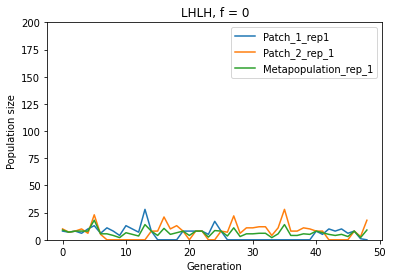

In [106]:
plt.title(f"LHLH, f = {f}")
plot_time_series(LHLH_nadult_matrix1,LHLH_nadult_matrix2,LHLH_metapop_nadult_matrix,range(1,2))


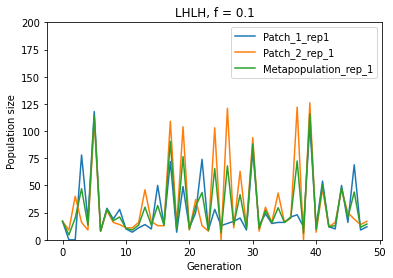

In [49]:
plt.title(f"LHLH, f = {f}")
plot_time_series(LHLH_nadult_matrix1,LHLH_nadult_matrix2,LHLH_metapop_nadult_matrix,range(1,2))

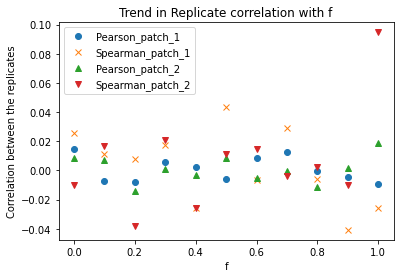

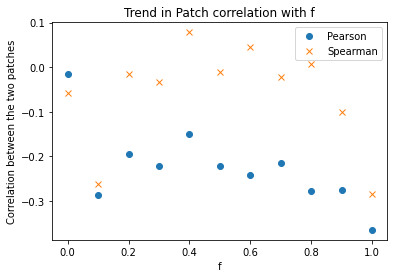

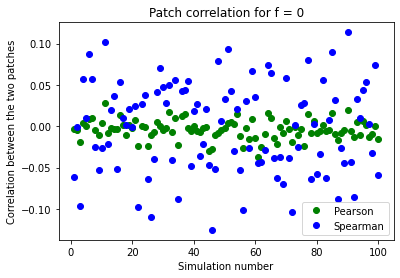

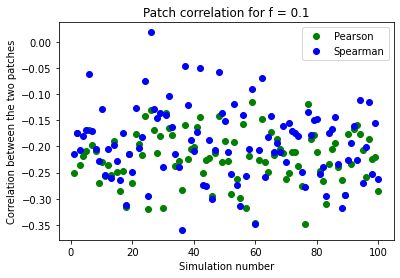

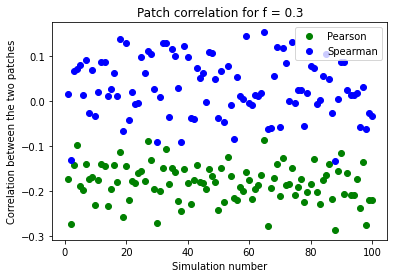

In [53]:
## Trend in Patch correlation with f
## repeat the whole simulation 100 times for each value of f. For f = 0 (CM), f = 0.1 (LMM), f = 0.3 (HMM); store the Pearson correlation and Spearman correlation between the two patches for each of the 100 simulations  

f_arr = np.arange(0,1.1,0.1)
simulations = 100
corr_sim_arr = np.zeros([6,simulations]) # row 1 : f = 0 Pearson correlation; row 2 : f = 0 Spearman correlation; row 3 : f = 0.1 Pearson correlation; row 4 : f = 0.1 Spearman correlation; row 5 : f = 0.3 Pearson correlation; row 6 : f = 0.3 Spearman correlation
for j in range(simulations):
    corr_replicates_arr = np.zeros([4,len(f_arr)]) #first and second rows are Pearson correlation and Spearman correlation of first patch; third and fourth rows are Pearson correlation and Spearman correlation of second patch
    corr_patches_arr = np.zeros([2,len(f_arr)]) #first row is Pearson correlation and second row is Spearman correlation
    for i in range(len(f_arr)):
        f = f_arr[i]
        LHLH_nadult_matrix1,LHLH_extinctions_matrix1,LHLH_nadult_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,0.1,1.49,numegg,0.1,1.49,generations,replicates)
        #transform the time series data
        transformed_LHLH_nadult_matrix1 = log_diff(LHLH_nadult_matrix1)
        transformed_LHLH_nadult_matrix2 = log_diff(LHLH_nadult_matrix2)
        corr_replicates_arr[0,i] = Pearson_corr_replicates(transformed_LHLH_nadult_matrix1)
        corr_replicates_arr[1,i] = Spearman_corr_replicates(transformed_LHLH_nadult_matrix1)
        corr_replicates_arr[2,i] = Pearson_corr_replicates(transformed_LHLH_nadult_matrix2)
        corr_replicates_arr[3,i] = Spearman_corr_replicates(transformed_LHLH_nadult_matrix2)
        corr_patches_arr[0,i] = Pearson_corr_patches(transformed_LHLH_nadult_matrix1,transformed_LHLH_nadult_matrix2)
        corr_patches_arr[1,i] = Spearman_corr_patches(transformed_LHLH_nadult_matrix1 ,transformed_LHLH_nadult_matrix2 )
    corr_sim_arr[0,j] = corr_patches_arr[0,0]
    corr_sim_arr[1,j] = corr_patches_arr[1,0]
    corr_sim_arr[2,j] = corr_patches_arr[0,1]
    corr_sim_arr[3,j] = corr_patches_arr[1,1]
    corr_sim_arr[4,j] = corr_patches_arr[0,3]
    corr_sim_arr[5,j] = corr_patches_arr[1,3]



# for the 100th simulation, plotting the replicate correlation and patch correlation with f

replcate_correlation_type = ['Pearson_patch_1','Spearman_patch_1','Pearson_patch_2','Spearman_patch_2']
replicate_marker = ['o','x','^','v']

plt.figure()
for i in range(len(replcate_correlation_type)):
    plt.plot(f_arr,corr_replicates_arr[i,:],replicate_marker[i],label=replcate_correlation_type[i])
plt.legend(replcate_correlation_type,loc = 'best')
plt.xlabel('f')
plt.ylabel('Correlation between the replicates')
plt.title('Trend in Replicate correlation with f')



patch_correlation_type = ['Pearson','Spearman']
patch_marker = ['o','x']
plt.figure()
for i in range(len(patch_correlation_type)):
    plt.plot(f_arr,corr_patches_arr[i,:],patch_marker[i],label=patch_correlation_type[i])
plt.legend(patch_correlation_type,loc = 'best')
plt.xlabel('f')
plt.ylabel('Correlation between the two patches')
plt.title('Trend in Patch correlation with f')

# plotting the patch correlation for f = 0, f = 0.1 and f = 0.3 vs simulation number
selected_f_arr = [0,0.1,0.3]
for i in range(len(selected_f_arr)):
    plt.figure()
    plt.plot(range(1,simulations+1),corr_sim_arr[2*i,:],'go',label='Pearson')
    plt.plot(range(1,simulations+1),corr_sim_arr[2*i+1,:],'bo',label='Spearman')
    plt.xlabel('Simulation number')
    plt.ylabel('Correlation between the two patches')
    plt.title(f'Patch correlation for f = {selected_f_arr[i]}')
    plt.legend(loc='best')

Text(0.5, 1.0, 'Mean and Std Dev of Spearman correlation between the two patches')

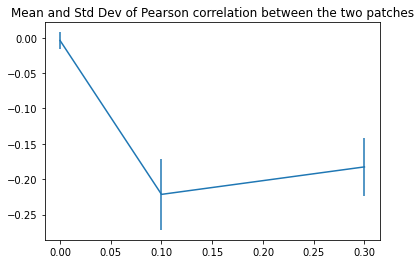

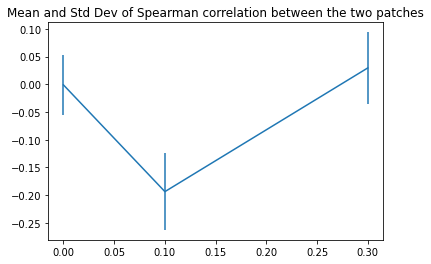

In [54]:
selected_f_arr = [0,0.1,0.3]
markers = ['^','o','p']
labels = ['f = 0','f = 0.1','f = 0.3']


corr_mean_Pearson = np.array([np.mean(corr_sim_arr[0,:]),np.mean(corr_sim_arr[2,:]),np.mean(corr_sim_arr[4,:])])
corr_mean_Spearman = np.array([np.mean(corr_sim_arr[1,:]),np.mean(corr_sim_arr[3,:]),np.mean(corr_sim_arr[5,:])])
corr_std_Pearson = np.array([np.std(corr_sim_arr[0,:]),np.std(corr_sim_arr[2,:]),np.std(corr_sim_arr[4,:])])
corr_std_Spearman = np.array([np.std(corr_sim_arr[1,:]),np.std(corr_sim_arr[3,:]),np.std(corr_sim_arr[5,:])])

plt.figure()
plt.errorbar(selected_f_arr,corr_mean_Pearson,corr_std_Pearson)
plt.title('Mean and Std Dev of Pearson correlation between the two patches')
plt.figure()
plt.errorbar(selected_f_arr,corr_mean_Spearman,corr_std_Spearman)
plt.title('Mean and Std Dev of Spearman correlation between the two patches')

Text(0.5, 1.0, 'LHLH population')

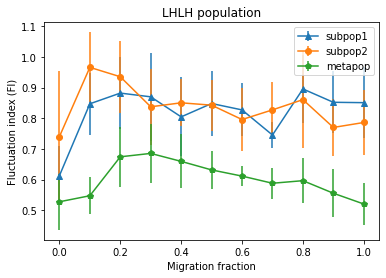

In [68]:
## Investigating the effect of migration rate on the metapopulation stability (FI)
# will vary f from 0 to 1 in steps of 0.1
f_arr = np.arange(0,1.1,0.1)
FI_mean_arr = np.zeros([3,len(f_arr)]) # 1st row for patch 1, 2nd row for patch 2 and 3rd row for metapopulation
FI_std_arr = np.zeros([3,len(f_arr)]) 
for i in range(len(f_arr)):
    f = f_arr[i]
    LHLH_nadult_matrix1,LHLH_extinctions_matrix1,LHLH_nadult_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,0.1,1.49,numegg,0.1,1.49,generations,replicates)
    LHLH_metapop_nadult_matrix,LHLH_metapop_extinctions_matrix = Metapop_matrices(LHLH_nadult_matrix1,LHLH_extinctions_matrix1,LHLH_nadult_matrix2,LHLH_extinctions_matrix2)
    FI_mean_arr[0,i],FI_std_arr[0,i] = FI_numadult_matrix(LHLH_nadult_matrix1)
    FI_mean_arr[1,i],FI_std_arr[1,i] = FI_numadult_matrix(LHLH_nadult_matrix2)
    FI_mean_arr[2,i],FI_std_arr[2,i] = FI_numadult_matrix(LHLH_metapop_nadult_matrix)
populations = ['subpop1', 'subpop2', 'metapop']
markers = ['^','o','p']
plt.figure()
for i in range(len(populations)):
    plt.errorbar(f_arr,FI_mean_arr[i,:],FI_std_arr[i,:],marker=markers[i],label=populations[i])
plt.legend(populations)
plt.xlabel('Migration fraction')
plt.ylabel('Fluctuation index (FI)')
plt.title('LHLH population')

Text(0.5, 1.0, 'LHLH population')

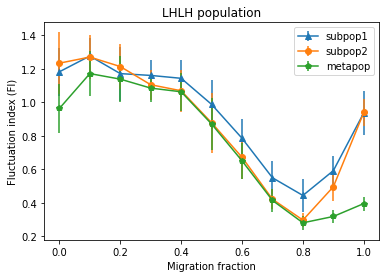

In [50]:
## Investigating the effect of migration rate on the metapopulation stability (FI)
# will vary f from 0 to 1 in steps of 0.1
f_arr = np.arange(0,1.1,0.1)
FI_mean_arr = np.zeros([3,len(f_arr)]) # 1st row for patch 1, 2nd row for patch 2 and 3rd row for metapopulation
FI_std_arr = np.zeros([3,len(f_arr)]) 
for i in range(len(f_arr)):
    f = f_arr[i]
    LHLH_nadult_matrix1,LHLH_extinctions_matrix1,LHLH_nadult_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,1.76,1.49,numegg,1.76,1.49,generations,replicates)
    LHLH_metapop_nadult_matrix,LHLH_metapop_extinctions_matrix = Metapop_matrices(LHLH_nadult_matrix1,LHLH_extinctions_matrix1,LHLH_nadult_matrix2,LHLH_extinctions_matrix2)
    FI_mean_arr[0,i],FI_std_arr[0,i] = FI_numadult_matrix(LHLH_nadult_matrix1)
    FI_mean_arr[1,i],FI_std_arr[1,i] = FI_numadult_matrix(LHLH_nadult_matrix2)
    FI_mean_arr[2,i],FI_std_arr[2,i] = FI_numadult_matrix(LHLH_metapop_nadult_matrix)
populations = ['subpop1', 'subpop2', 'metapop']
markers = ['^','o','p']
plt.figure()
for i in range(len(populations)):
    plt.errorbar(f_arr,FI_mean_arr[i,:],FI_std_arr[i,:],marker=markers[i],label=populations[i])
plt.legend(populations)
plt.xlabel('Migration fraction')
plt.ylabel('Fluctuation index (FI)')
plt.title('LHLH population')

In [ ]:
## do 100 simulations and get an average of the FI for f = 0, f = 0.1 and f = 0.3

0.0
0.1989795918367347 0.20408163265306123
0.19387755102040816
0.1
0.20918367346938777 0.20153061224489796
0.10459183673469388
0.2
0.21683673469387754 0.23214285714285715
0.06377551020408163
0.30000000000000004
0.2372448979591837 0.23724489795918363
0.08418367346938774
0.4
0.20153061224489793 0.1760204081632653
0.04846938775510204
0.5
0.21173469387755103 0.21428571428571427
0.0586734693877551
0.6000000000000001
0.2142857142857143 0.18367346938775508
0.05612244897959183
0.7000000000000001
0.21938775510204084 0.20918367346938777
0.06632653061224489
0.8
0.20408163265306123 0.20408163265306123
0.05612244897959183
0.9
0.20408163265306123 0.22193877551020408
0.053571428571428575
1.0
0.20408163265306123 0.1683673469387755
0.0586734693877551


Text(0.5, 1.0, 'LHLH population')

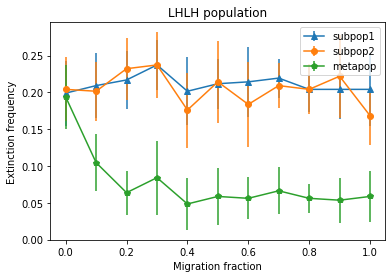

In [101]:
## Investigating the effect of migration rate on the metapopulation persistence (extinction frequency)
# will vary f from 0 to 1 in steps of 0.1
f_arr = np.arange(0,1.1,0.1)
extinc_freq_mean_arr = np.zeros([3,len(f_arr)]) # 1st row for patch 1, 2nd row for patch 2 and 3rd row for metapopulation
extinc_freq_std_arr = np.zeros([3,len(f_arr)])
for i in range(len(f_arr)):
    f = f_arr[i]
    print(f)
    LHLH_nadult_matrix1,LHLH_extinctions_matrix1,LHLH_nadult_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,0.1,1.49,numegg,0.1,1.49,generations,replicates)
    LHLH_metapop_nadult_matrix,LHLH_metapop_extinctions_matrix = Metapop_matrices(LHLH_nadult_matrix1,LHLH_extinctions_matrix1,LHLH_nadult_matrix2,LHLH_extinctions_matrix2)
    extinc_freq_mean_arr[0,i],extinc_freq_std_arr[0,i],extinc_freq_mean_arr[1,i],extinc_freq_std_arr[1,i]  = Extinction_freq(LHLH_extinctions_matrix1,LHLH_extinctions_matrix2)
    print(extinc_freq_mean_arr[0,i],extinc_freq_mean_arr[1,i])
    extinc_freq_mean_arr[2,i],extinc_freq_std_arr[2,i] = metapop_extinc_freq(LHLH_metapop_extinctions_matrix)
    print(extinc_freq_mean_arr[2,i])
populations = ['subpop1', 'subpop2', 'metapop']
markers = ['^','o','p']
plt.figure()
for i in range(len(populations)):
    plt.errorbar(f_arr,extinc_freq_mean_arr[i,:],extinc_freq_std_arr[i,:],marker=markers[i],label=populations[i])
plt.legend(populations)
plt.xlabel('Migration fraction')
plt.ylabel('Extinction frequency')
plt.title('LHLH population')
    

In [100]:
replicates

8